In [106]:
import pandas as pd
import torch
import numpy as np
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from collections import Counter
import glob
import os
from tqdm import tqdm

# Load and Sample Participant Data

In [210]:
def load_participant_data(file_path):

        '''
        input: 
        A csv file from the DREAMT dataset
    
        return: a dataframes containing 4 sleep stages (W, N1, N2, R), no mising values and certain columns dropped with high null ratios
        '''

        df = pd.read_csv(file_path).drop(columns=['Obstructive_Apnea', 'Central_Apnea', 'Hypopnea', 'Multiple_Events'])

        df = df[~df['Sleep_Stage'].isin(['N3', 'P'])]

        return df

In [211]:
# Create a custom Dataset
class SleepStageDataset():
    def __init__(self, dataframe, sample_rate=64, segment_seconds=30, segments = None):
        self.df = dataframe
        self.sample_rate = sample_rate
        self.segment_seconds = segment_seconds
        self.samples_per_segment = sample_rate * segment_seconds
        self.segments = segments
        
        if self.segments == None:
            self.segments = self.create_segments()
        
         # Create a mapping dictionary
        self.label_map = {
            'W': 0,   # Wake
            'N1': 1,  # NREM stage 1
            'N2': 2,  # NREM stage 2
            'R': 3    # REM
        }
        
    def create_segments(self):
        segments = []
        n_segments = len(self.df) // self.samples_per_segment
        FEATURES = ['BVP', 'ACC_X', 'ACC_Y', 'ACC_Z', 'TEMP', 'EDA', 'HR', 'IBI']
        
        for i in range(n_segments):
            start_idx = i * self.samples_per_segment
            end_idx = start_idx + self.samples_per_segment
            
            segment = self.df.iloc[start_idx:end_idx].copy()
            
            if len(segment) < self.samples_per_segment:
                continue
                
            # Get the most common sleep stage in this segment
            sleep_stage_column = 'Sleep_Stage'  # Adjust to match your actual column name
            if sleep_stage_column in segment.columns:
                label = segment[sleep_stage_column].mode()[0]
                
                # Create feature array
                features = np.zeros((len(FEATURES), self.samples_per_segment))
                for j, feature in enumerate(FEATURES):
                    if feature in segment.columns:
                        features[j, :] = segment[feature].values
                
                segments.append((features, label))
        
        return segments
    
    def __len__(self):
        return len(self.segments)

    # Function to convert string labels to integers
    def convert_labels(string_labels):
        return [label_map[label] for label in string_labels]

    def __getitem__(self, idx):
        features, label = self.segments[idx]

        features_tensor = torch.tensor(features, dtype=torch.float32).unsqueeze(0)  # Ensure float32
        label_idx = torch.tensor(self.label_map[label], dtype=torch.long)

        return features_tensor, label_idx


In [212]:
def create_balanced_dataset(participant_files, target_N2=4761, target_W=4761):
    """
    Simple approach: Keep all N1 and R samples, randomly subsample W and N2
    """
    # Collect all samples
    all_samples = {'W': [], 'N1': [], 'N2': [], 'R': []}
    
    for i, file_path in enumerate(participant_files):
        if i % 5 == 0:
            print(f"{round(i*100/len(participant_files), 2)}% of Files processed.")
            
        df = load_participant_data(file_path)
        dataset = SleepStageDataset(df)
        
        for features, label in dataset.segments:
            if label != 'Missing':
                all_samples[label].append((features, label))
    
    # Print initial counts
    initial_counts = {label: len(samples) for label, samples in all_samples.items()}
    print(f"Initial class distribution: {initial_counts}")
    
    # Subsample the majority classes
    balanced_data = []
    
    # Keep all samples from minority classes
    balanced_data.extend(all_samples['N1'])
    balanced_data.extend(all_samples['R'])
    
    # Randomly sample from majority classes
    import random
    random.shuffle(all_samples['W'])
    random.shuffle(all_samples['N2'])
    
    balanced_data.extend(all_samples['W'][:target_W])
    balanced_data.extend(all_samples['N2'][:target_N2])
    
    # Print final counts
    final_counts = {
        'W': min(len(all_samples['W']), target_W),
        'N1': len(all_samples['N1']),
        'N2': min(len(all_samples['N2']), target_N2),
        'R': len(all_samples['R'])
    }
    print(f"Final class distribution: {final_counts}")
    
    random.shuffle(balanced_data)
    
    return SleepStageDataset(dataframe=None, segments=balanced_data)

In [213]:
file_paths = glob.glob(os.path.join('/Users/daviddechantsreiter/Desktop/WPI/Courses/Machine Learning/sleep-ml/physionet_data', '*.csv'))
resampled_data = create_balanced_dataset(file_paths)

0.0% of Files processed.
9.43% of Files processed.
18.87% of Files processed.
28.3% of Files processed.
37.74% of Files processed.
47.17% of Files processed.
56.6% of Files processed.
66.04% of Files processed.
75.47% of Files processed.
84.91% of Files processed.
94.34% of Files processed.
Initial class distribution: {'W': 11738, 'N1': 4761, 'N2': 20327, 'R': 4216}
Final class distribution: {'W': 4761, 'N1': 4761, 'N2': 4761, 'R': 4216}


# CNN

In [214]:
# Define the CNN model
class SleepSimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SleepSimpleCNN, self).__init__()
        
        # Store input dimensions
        self.num_features = 8
        self.sample_rate = 64
        self.segment_length = 30
        
        # Convolutional layers
        self.conv_layers = nn.Sequential(
            # First conv block
            nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            
            # Second conv block
            nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            
            # Third conv block
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2))
        )
        
        # Calculate the size after convolutions and pooling
        # This depends on your input size and may need adjustment
        flattened_size = self._get_conv_output_size()
        
        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(flattened_size, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
    
    def _get_conv_output_size(self):
        # This helper function calculates the size of the flattened features
        # after the convolutional layers
        # You need to adjust the input size based on your data
        dummy_input = torch.zeros(1, 1, self.num_features, self.sample_rate * self.segment_length)
        output = self.conv_layers(dummy_input)
        return output.numel() // output.shape[0]
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        return x

In [215]:
class SleepCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(SleepCNN, self).__init__()
        
        # Store input dimensions
        self.num_features = 8
        self.sample_rate = 64
        self.segment_length = 30
        
        # Feature extraction path 1: temporal features
        self.temporal_path = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1, 7), padding=(0, 3)),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=(1, 5), padding=(0, 2)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        # Feature extraction path 2: cross-channel features
        self.channel_path = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(3, 1), padding=(1, 0)),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=(3, 1), padding=(1, 0)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        # Combined path
        self.combined_path = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.3)
        )
        
        # Calculate flattened size
        self.flattened_size = self._get_conv_output_size()
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(self.flattened_size, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    
    def _get_conv_output_size(self):
        dummy_input = torch.zeros(1, 1, self.num_features, self.sample_rate * self.segment_length)
    
        temp_out = self.temporal_path(dummy_input)
        chan_out = self.channel_path(dummy_input)
        
        # Print shapes for debugging
        # print("Temporal path output shape:", temp_out.shape)
        # print("Channel path output shape:", chan_out.shape)
        
        combined = torch.cat([temp_out, chan_out], dim=1)
        out = self.combined_path(combined)
    
        return out.numel() // out.shape[0]
    
    def forward(self, x):
        # Temporal features
        temp_features = self.temporal_path(x)
        
        # Channel features
        chan_features = self.channel_path(x)
        
        # Combine features
        combined = torch.cat([temp_features, chan_features], dim=1)
        
        # Process combined features
        features = self.combined_path(combined)
        
        # Flatten and classify
        features = features.view(features.size(0), -1)
        output = self.classifier(features)
        
        return output

In [216]:
# Training function
def train_model(model, train_loader, val_loader, num_epochs=5, learning_rate=0.001):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model.to(device)
    
    #class_weights = torch.tensor([1.0, 743/64, 743/334, 743/80], dtype=torch.float32, device=device)  # Avoid zero
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs = inputs.float().to(device)
            labels = labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * inputs.size(0)
        
        train_loss = train_loss / len(train_loader.dataset)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = correct / total
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')
    
    return model

In [227]:
# Assuming your_dataframe is your pandas DataFrame with all required columns
    
# Create datasets and dataloaders
dataset = resampled_data
    
# Split into train and validation sets
# For proper cross-validation, split by participants
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    
# Initialize and train the model
num_classes = 4  # Adjust based on your sleep stage categories
model = SleepSimpleCNN(num_classes)
    
trained_model = train_model(model, train_loader, val_loader)
    
# Save the model
torch.save(trained_model.state_dict(), 'sleep_stage_simple_cnn.pth')

Epoch 1/5:
Train Loss: 1.6350, Val Loss: 1.3757, Val Accuracy: 0.2678
Epoch 2/5:
Train Loss: 1.3812, Val Loss: 1.3841, Val Accuracy: 0.2741
Epoch 3/5:
Train Loss: 1.3882, Val Loss: 1.3849, Val Accuracy: 0.2597
Epoch 4/5:
Train Loss: 1.3854, Val Loss: 1.3850, Val Accuracy: 0.2681
Epoch 5/5:
Train Loss: 1.3851, Val Loss: 1.3852, Val Accuracy: 0.2454


In [228]:
def evaluate_model(model, data_loader, device, num_classes):
    model.eval()
    
    # Initialize lists to store true and predicted labels
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            # Collect the results
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    # Convert to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate F1 scores
    f1_micro = f1_score(y_true, y_pred, average='micro')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    f1_per_class = f1_score(y_true, y_pred, average=None)
    
    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Print classification report
    report = classification_report(y_true, y_pred)
    
    # Return all metrics
    results = {
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'f1_per_class': f1_per_class,
        'confusion_matrix': cm,
        'classification_report': report
    }
    
    return results

def plot_confusion_matrix(cm, class_names=None):
    """
    Plot confusion matrix with seaborn and matplotlib
    """
    plt.figure(figsize=(10, 8))
    
    # Create a readable confusion matrix plot
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

# Example usage:
def evaluate_and_visualize(model, val_loader):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model = model.to(device)
    
    # Assuming you have these class names - replace with your actual sleep stage classes
    class_names = ['Wake', 'N1', 'N2', 'REM']
    num_classes = len(class_names)
    
    # Get evaluation metrics
    results = evaluate_model(model, val_loader, device, num_classes)
    
    # Print F1 scores
    print(f"F1 Score (Micro): {results['f1_micro']:.4f}")
    print(f"F1 Score (Macro): {results['f1_macro']:.4f}")
    print(f"F1 Score (Weighted): {results['f1_weighted']:.4f}")
    
    print("\nF1 Score per class:")
    for i, score in enumerate(results['f1_per_class']):
        print(f"  {class_names[i]}: {score:.4f}")
    
    print("\nClassification Report:")
    print(results['classification_report'])
    
    # Plot confusion matrix
    plot_confusion_matrix(results['confusion_matrix'], class_names)
    
    return results

F1 Score (Micro): 0.2454
F1 Score (Macro): 0.0985
F1 Score (Weighted): 0.0967

F1 Score per class:
  Wake: 0.3941
  N1: 0.0000
  N2: 0.0000
  REM: 0.0000

Classification Report:
              precision    recall  f1-score   support

           0       0.25      1.00      0.39       908
           1       0.00      0.00      0.00       960
           2       0.00      0.00      0.00       987
           3       0.00      0.00      0.00       845

    accuracy                           0.25      3700
   macro avg       0.06      0.25      0.10      3700
weighted avg       0.06      0.25      0.10      3700



/Users/daviddechantsreiter/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/daviddechantsreiter/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/daviddechantsreiter/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

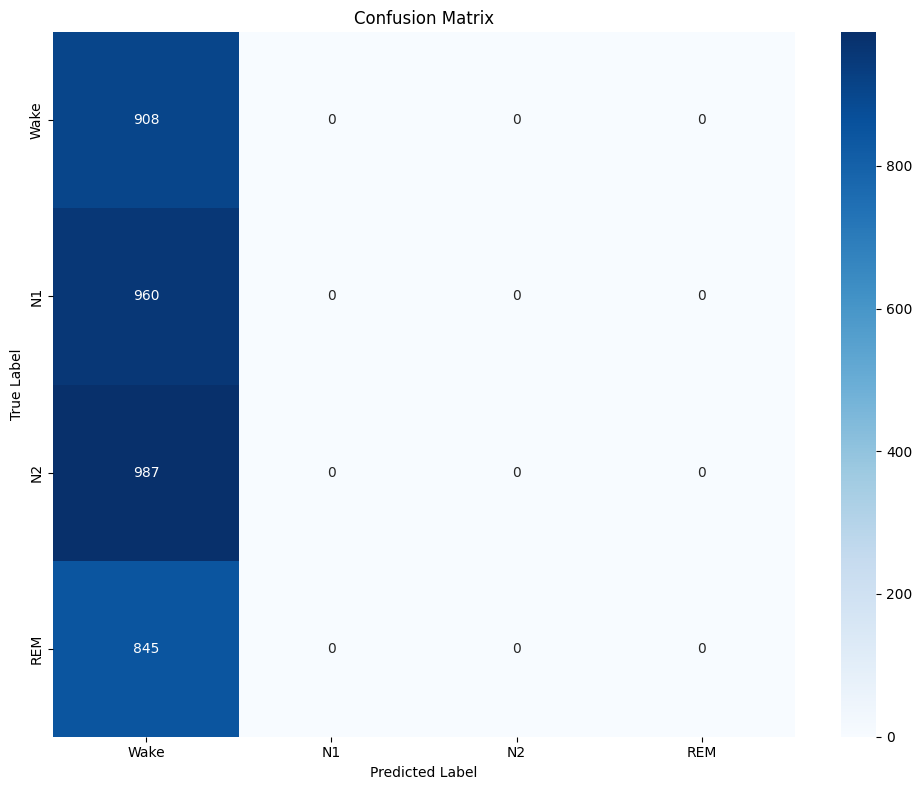

In [229]:
# Evaluate on validation set
eval_results = evaluate_and_visualize(trained_model, val_loader)